# Machine Learning para Previsão de Rendimento de Safra

**Autor:** Gustavo Zanette Martins  
**RM:** 564523  
**Disciplina:** Fase 5 - Tratores digitais - Hardwares para IA

---

## Objetivo

Este notebook tem como objetivo desenvolver modelos de Machine Learning para prever o **Rendimento (t/ha)** de diferentes culturas agrícolas com base em variáveis climáticas e de solo. Além disso, realizaremos análise de clusterização para identificar padrões e outliers nos dados.

### Dados de Entrada
- **Arquivo:** `crop_yield.csv`
- **Variáveis:**
  - Cultura (categoria)
  - Precipitação (mm dia⁻¹)
  - Umidade específica a 2 m (g/kg)
  - Umidade relativa a 2 m (%)
  - Temperatura a 2 m (°C)
  - **Rendimento (t/ha)** (variável alvo)

### Metodologia
1. **Análise Exploratória de Dados (EDA)**
2. **Clusterização** (identificação de padrões e outliers)
3. **Modelagem Supervisionada** com 5 modelos distintos
4. **Avaliação e Comparação** dos modelos
5. **Conclusões e Limitações**


## 0. Setup - Importação de Bibliotecas e Configurações

### Instalar Bibliotecas (Opcional)

In [2]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)


In [3]:
# Bibliotecas fundamentais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelos de ML
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

# Clusterização
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Bibliotecas importadas com sucesso!")
print(f"📊 Pandas versão: {pd.__version__}")
print(f"🔢 NumPy versão: {np.__version__}")
import sklearn
print(f"🤖 Scikit-learn versão: {sklearn.__version__}")


✅ Bibliotecas importadas com sucesso!
📊 Pandas versão: 2.2.2
🔢 NumPy versão: 1.26.4
🤖 Scikit-learn versão: 1.5.1


## 1. Carga e Qualidade dos Dados


In [4]:
# Carregamento dos dados
df = pd.read_csv('crop_yield.csv')

print("📋 Informações Básicas do Dataset:")
print(f"Shape: {df.shape}")
print(f"Colunas: {list(df.columns)}")
print("\n" + "="*50)

# Primeiras linhas
print("\n🔍 Primeiras 5 linhas:")
display(df.head())

# Informações sobre tipos de dados
print("\n📊 Informações sobre os dados:")
df.info()


📋 Informações Básicas do Dataset:
Shape: (156, 6)
Colunas: ['Crop', 'Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Yield']


🔍 Primeiras 5 linhas:


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800



📊 Informações sobre os dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


In [5]:
# Renomear colunas para facilitar o trabalho
df.columns = ['Cultura', 'Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura', 'Rendimento']

print("✅ Colunas renomeadas:")
print(list(df.columns))

# Verificação de valores ausentes
print("\n🔍 Valores ausentes por coluna:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal de valores ausentes: {missing_values.sum()}")

# Verificação de duplicados
duplicates = df.duplicated().sum()
print(f"\n🔄 Registros duplicados: {duplicates}")

# Estatísticas descritivas
print("\n📈 Estatísticas descritivas das variáveis numéricas:")
display(df.describe())


✅ Colunas renomeadas:
['Cultura', 'Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura', 'Rendimento']

🔍 Valores ausentes por coluna:
Cultura               0
Precipitacao          0
Umidade_Especifica    0
Umidade_Relativa      0
Temperatura           0
Rendimento            0
dtype: int64

Total de valores ausentes: 0

🔄 Registros duplicados: 0

📈 Estatísticas descritivas das variáveis numéricas:


,Precipitacao,Umidade_Especifica,Umidade_Relativa,Temperatura,Rendimento
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


🌱 Análise das Culturas:
Número de culturas únicas: 4

Distribuição por cultura:
Cultura
Cocoa, beans       39
Oil palm fruit     39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64


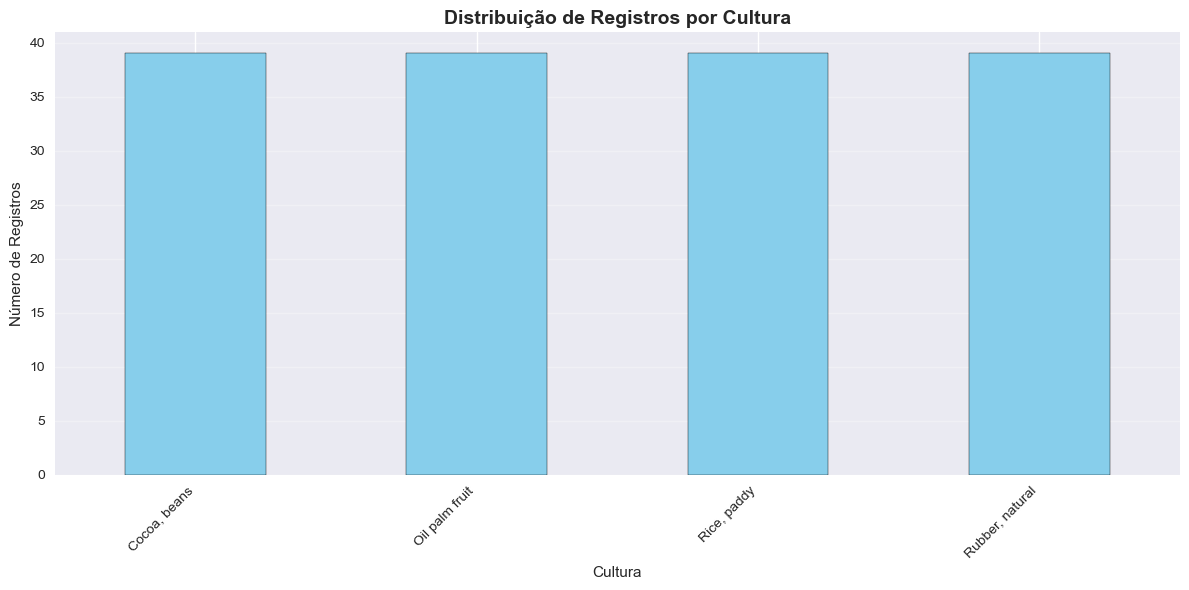


🌡️ Validação de ranges físicos:
Temperatura - Min: 25.56°C, Max: 26.81°C
Umidade Relativa - Min: 82.11%, Max: 86.10%
Precipitação - Min: 1934.62mm, Max: 3085.79mm
Umidade Específica - Min: 17.54g/kg, Max: 18.70g/kg
Rendimento - Min: 5249.00t/ha, Max: 203399.00t/ha


In [6]:
# Análise das culturas
print("🌱 Análise das Culturas:")
print(f"Número de culturas únicas: {df['Cultura'].nunique()}")
print("\nDistribuição por cultura:")
cultura_counts = df['Cultura'].value_counts()
print(cultura_counts)

# Visualização da distribuição das culturas
plt.figure(figsize=(12, 6))
cultura_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição de Registros por Cultura', fontsize=14, fontweight='bold')
plt.xlabel('Cultura')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Verificar ranges físicos das variáveis
print("\n🌡️ Validação de ranges físicos:")
print(f"Temperatura - Min: {df['Temperatura'].min():.2f}°C, Max: {df['Temperatura'].max():.2f}°C")
print(f"Umidade Relativa - Min: {df['Umidade_Relativa'].min():.2f}%, Max: {df['Umidade_Relativa'].max():.2f}%")
print(f"Precipitação - Min: {df['Precipitacao'].min():.2f}mm, Max: {df['Precipitacao'].max():.2f}mm")
print(f"Umidade Específica - Min: {df['Umidade_Especifica'].min():.2f}g/kg, Max: {df['Umidade_Especifica'].max():.2f}g/kg")
print(f"Rendimento - Min: {df['Rendimento'].min():.2f}t/ha, Max: {df['Rendimento'].max():.2f}t/ha")


## 2. Análise Exploratória de Dados (EDA)

### 2.1 Estatísticas Descritivas por Cultura


📊 Estatísticas do Rendimento por Cultura:


,count,mean,median,std,min,max
Cultura,,,,,,
"Cocoa, beans",39,8883.13,8848.0,1745.03,5765,13056
Oil palm fruit,39,175804.69,175629.0,14919.87,142425,203399
"Rice, paddy",39,32099.67,31101.0,4789.95,24686,42550
"Rubber, natural",39,7824.90,7817.0,1600.26,5249,10285


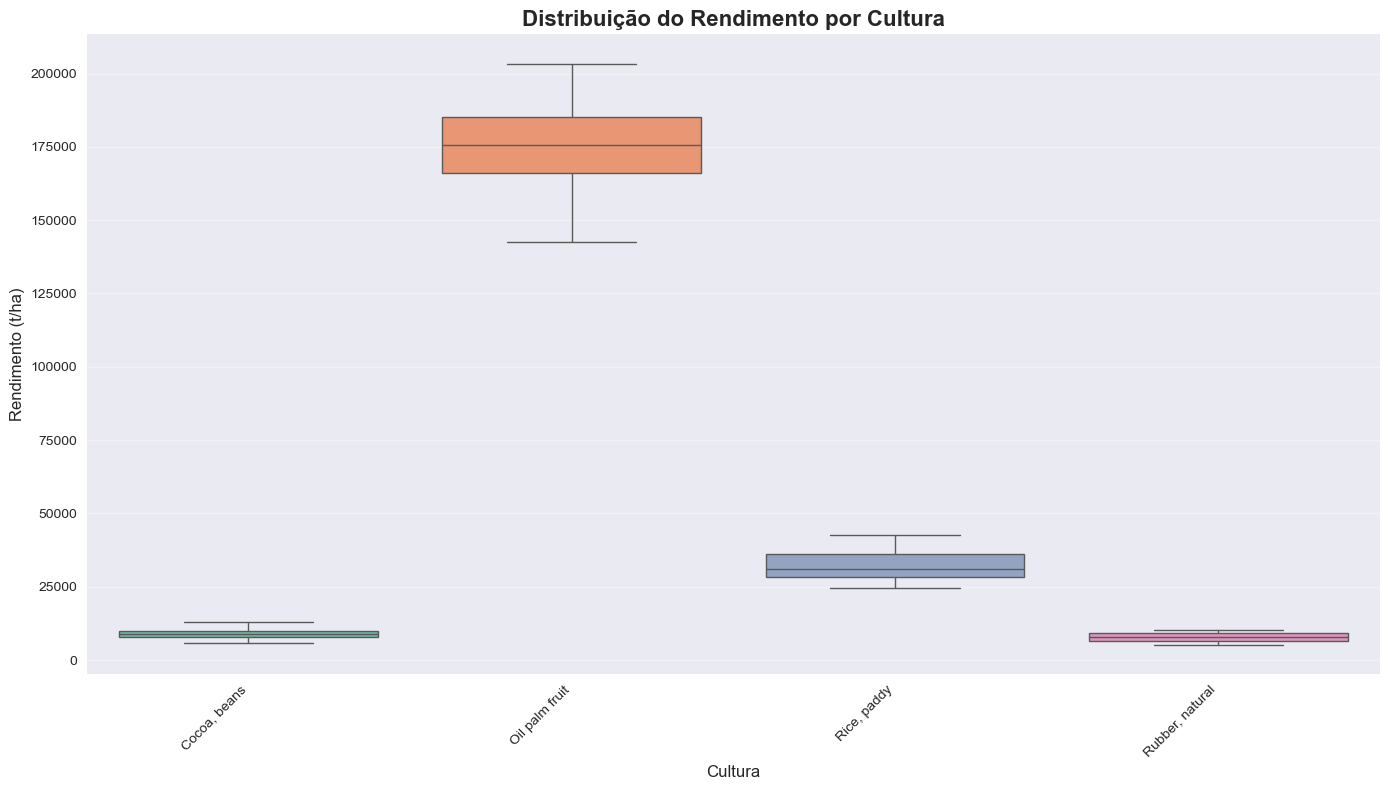


🌤️ Médias das Variáveis Climáticas por Cultura:


,Precipitacao,Umidade_Especifica,Umidade_Relativa,Temperatura
Cultura,,,,
"Cocoa, beans",2486.5,18.2,84.74,26.18
Oil palm fruit,2486.5,18.2,84.74,26.18
"Rice, paddy",2486.5,18.2,84.74,26.18
"Rubber, natural",2486.5,18.2,84.74,26.18


In [7]:
# Estatísticas por cultura
print("📊 Estatísticas do Rendimento por Cultura:")
rendimento_por_cultura = df.groupby('Cultura')['Rendimento'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
display(rendimento_por_cultura)

# Visualização boxplot do rendimento por cultura
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Cultura', y='Rendimento', palette='Set2')
plt.title('Distribuição do Rendimento por Cultura', fontsize=16, fontweight='bold')
plt.xlabel('Cultura', fontsize=12)
plt.ylabel('Rendimento (t/ha)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estatísticas das variáveis climáticas por cultura
print("\n🌤️ Médias das Variáveis Climáticas por Cultura:")
variaveis_climaticas = ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']
clima_por_cultura = df.groupby('Cultura')[variaveis_climaticas].mean().round(2)
display(clima_por_cultura)


### 2.2 Distribuições e Correlações


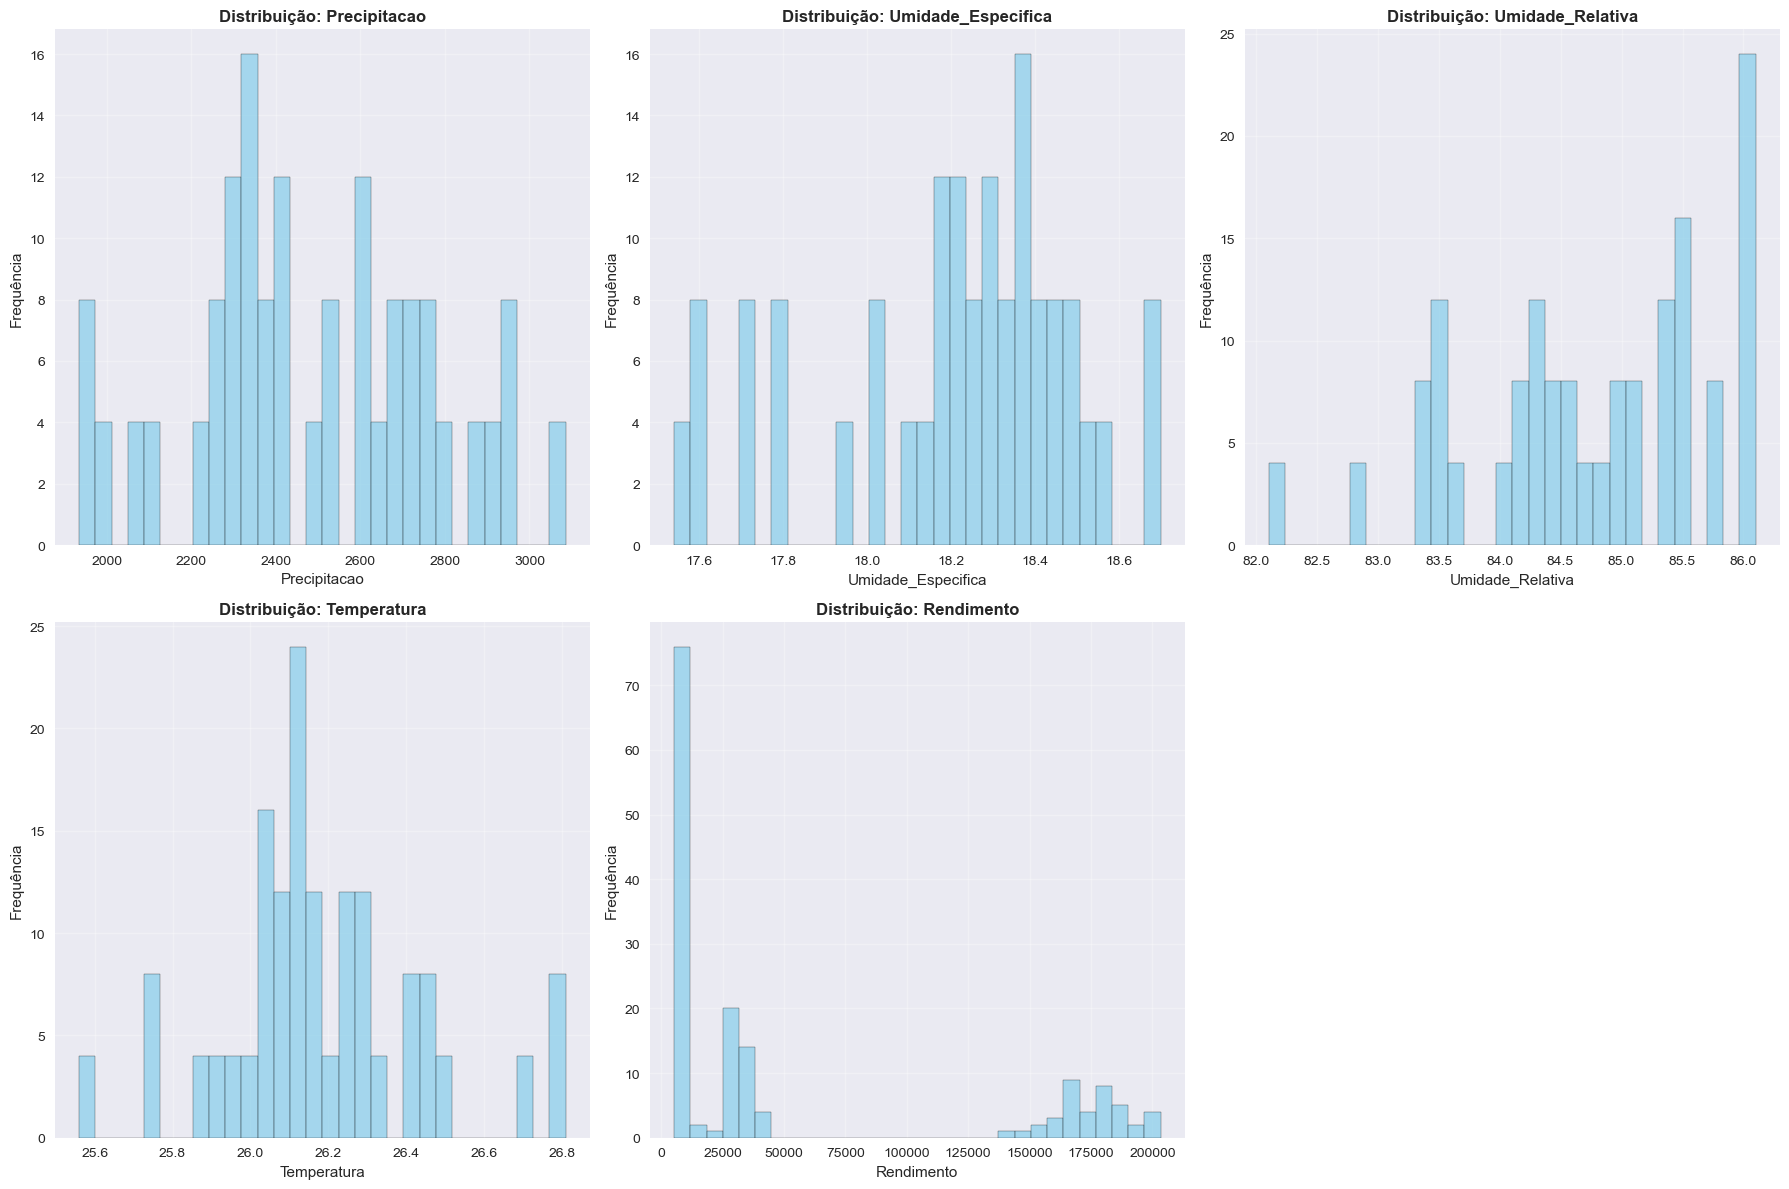

🔗 Matriz de Correlação:


,Precipitacao,Umidade_Especifica,Umidade_Relativa,Temperatura,Rendimento
Precipitacao,1.000,0.488,0.749,-0.084,0.019
Umidade_Especifica,0.488,1.000,0.437,0.699,0.013
Umidade_Relativa,0.749,0.437,1.000,-0.337,0.000
Temperatura,-0.084,0.699,-0.337,1.000,0.013
Rendimento,0.019,0.013,0.000,0.013,1.000


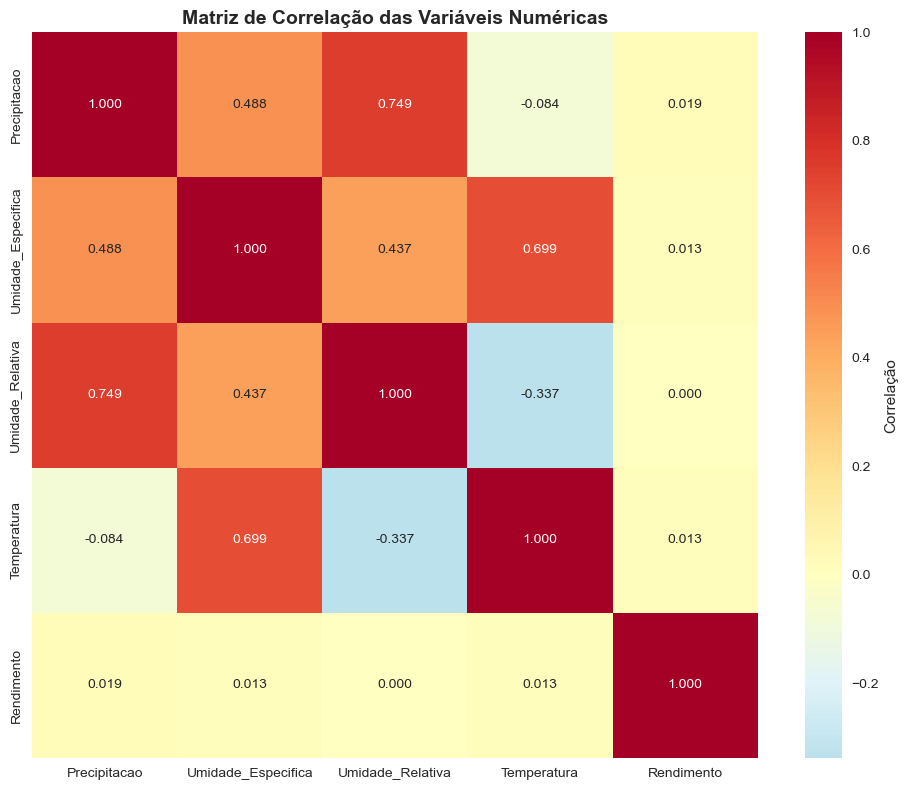

In [8]:
# Distribuições das variáveis numéricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

variaveis_numericas = ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura', 'Rendimento']

for i, var in enumerate(variaveis_numericas):
    # Histograma
    axes[i].hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribuição: {var}', fontweight='bold')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(alpha=0.3)

# Remover subplot extra
axes[5].remove()

plt.tight_layout()
plt.show()

# Matriz de correlação
print("🔗 Matriz de Correlação:")
correlation_matrix = df[variaveis_numericas].corr()
display(correlation_matrix.round(3))

# Heatmap da correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 2.3 Relações Bivariadas com o Rendimento


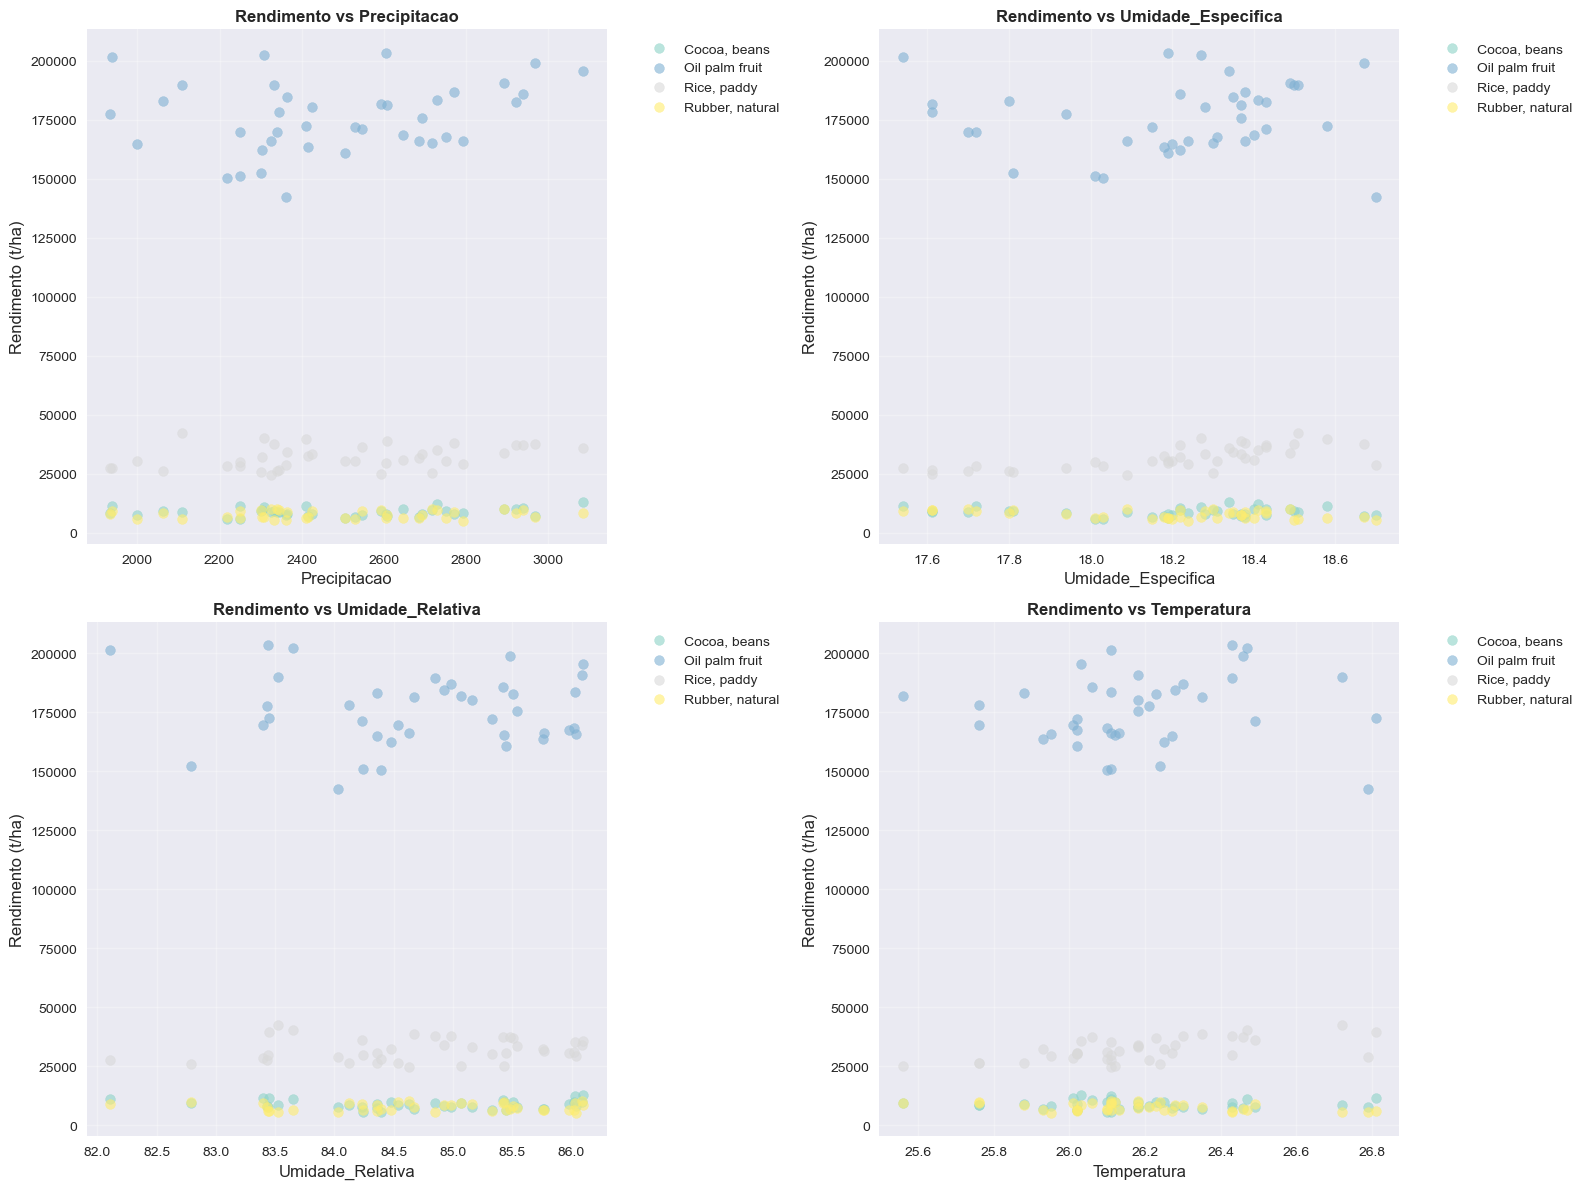

📈 Correlações com o Rendimento:
Precipitacao: 0.019
Temperatura: 0.013
Umidade_Especifica: 0.013
Umidade_Relativa: 0.000


In [9]:
# Scatter plots: Rendimento vs. variáveis climáticas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

variaveis_clima = ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']

for i, var in enumerate(variaveis_clima):
    # Scatter plot colorido por cultura
    culturas = df['Cultura'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(culturas)))
    
    for j, cultura in enumerate(culturas):
        cultura_data = df[df['Cultura'] == cultura]
        axes[i].scatter(cultura_data[var], cultura_data['Rendimento'], 
                       alpha=0.6, label=cultura, color=colors[j], s=50)
    
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Rendimento (t/ha)', fontsize=12)
    axes[i].set_title(f'Rendimento vs {var}', fontweight='bold')
    axes[i].grid(alpha=0.3)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Correlações específicas com o rendimento
print("📈 Correlações com o Rendimento:")
correlacoes_rendimento = df[variaveis_numericas].corr()['Rendimento'].sort_values(ascending=False)
for var, corr in correlacoes_rendimento.items():
    if var != 'Rendimento':
        print(f"{var}: {corr:.3f}")


## 3. Clusterização e Identificação de Outliers

### 3.1 Preparação dos Dados para Clusterização


📊 Dados padronizados para clusterização:
Shape: (156, 5)


,Precipitacao,Umidade_Especifica,Umidade_Relativa,Temperatura,Rendimento
count,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,1.231921e-15,-5.277829e-15,9.889525e-15,4.907755e-15,-6.832142e-17
std,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00
min,-1.912735e+00,-2.263223e+00,-2.646141e+00,-2.396470e+00,-7.251721e-01
25%,-6.360164e-01,-5.907486e-01,-6.220290e-01,-6.286791e-01,-6.813127e-01
50%,-2.147065e-01,2.284228e-01,1.130962e-01,-2.059466e-01,-5.311151e-01
75%,8.026274e-01,6.721406e-01,7.777299e-01,4.473673e-01,1.619134e-01
max,2.077059e+00,1.696105e+00,1.371872e+00,2.407309e+00,2.097643e+00



🔍 Variância explicada pelo PCA:
PC1: 0.428
PC2: 0.319
Total: 0.748


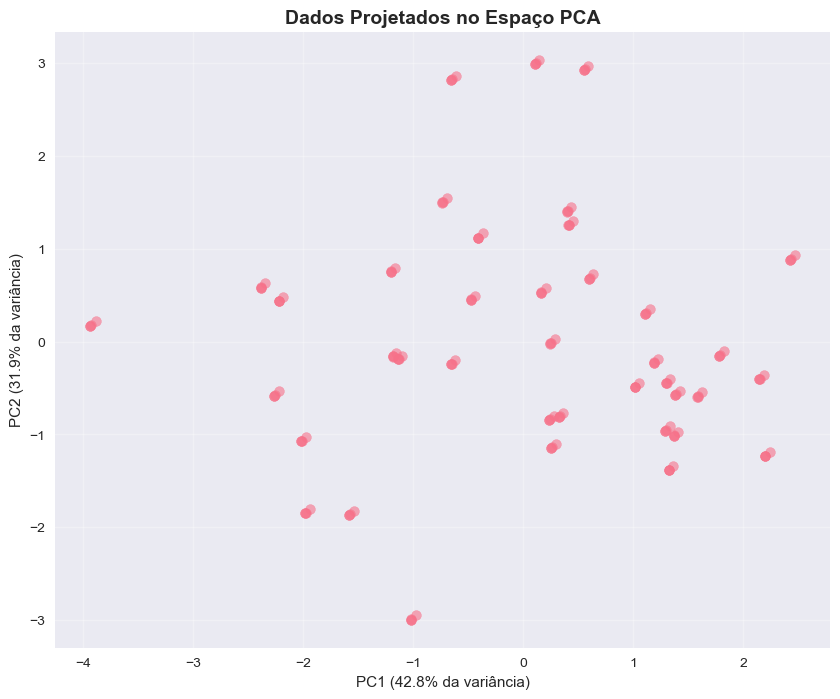

In [10]:
# Preparação dos dados numéricos para clusterização
dados_numericos = df[variaveis_numericas].copy()

# Padronização dos dados
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(dados_numericos)
dados_padronizados_df = pd.DataFrame(dados_padronizados, columns=variaveis_numericas)

print("📊 Dados padronizados para clusterização:")
print(f"Shape: {dados_padronizados_df.shape}")
display(dados_padronizados_df.describe())

# Análise PCA para visualização
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(dados_padronizados)

print(f"\n🔍 Variância explicada pelo PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total: {sum(pca.explained_variance_ratio_):.3f}")

# Visualização PCA
plt.figure(figsize=(10, 8))
plt.scatter(dados_pca[:, 0], dados_pca[:, 1], alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} da variância)')
plt.title('Dados Projetados no Espaço PCA', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()


### 3.2 Aplicação de Algoritmos de Clusterização


  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


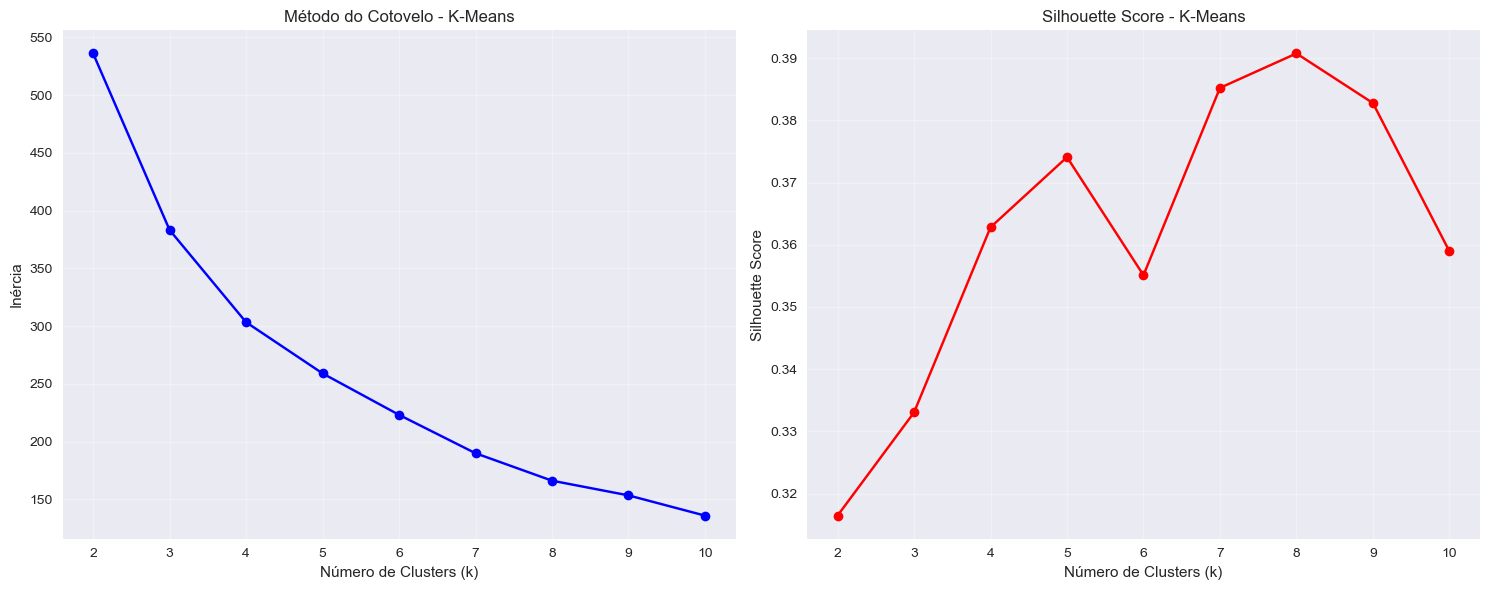

🎯 Número ótimo de clusters escolhido: 4
Silhouette Score para k=4: 0.363


In [11]:
# 1. K-Means Clustering
# Determinar número ótimo de clusters usando método do cotovelo
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_padronizados)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(dados_padronizados, kmeans.labels_))

# Visualizar método do cotovelo e silhouette score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia')
ax1.set_title('Método do Cotovelo - K-Means')
ax1.grid(alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score - K-Means')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Escolher k=4 baseado na análise
k_otimo = 4
print(f"🎯 Número ótimo de clusters escolhido: {k_otimo}")
print(f"Silhouette Score para k={k_otimo}: {silhouette_scores[k_otimo-2]:.3f}")

# Aplicar K-Means com k ótimo
kmeans = KMeans(n_clusters=k_otimo, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(dados_padronizados)


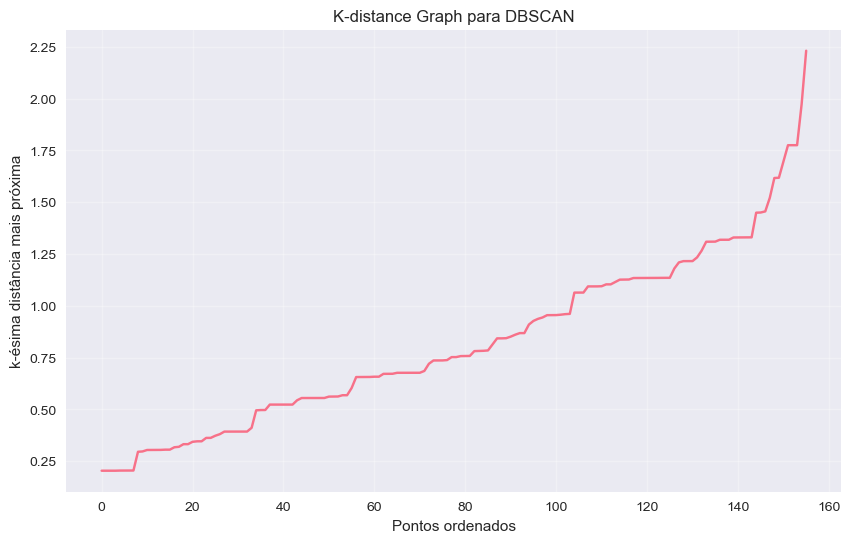

🔍 DBSCAN Results:
Número de clusters: 5
Número de outliers: 69
Silhouette Score: 0.07177173933977522

🎯 Gaussian Mixture Model:
Silhouette Score: 0.293


In [12]:
# 2. DBSCAN Clustering
# Testar diferentes valores de eps
from sklearn.neighbors import NearestNeighbors

# Determinar eps usando k-distance graph
k = 4  # MinPts = k+1 = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(dados_padronizados)
distances, indices = nbrs.kneighbors(dados_padronizados)
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Pontos ordenados')
plt.ylabel('k-ésima distância mais próxima')
plt.title('K-distance Graph para DBSCAN')
plt.grid(alpha=0.3)
plt.show()

# Aplicar DBSCAN
eps = 0.8  # Valor escolhido baseado no k-distance graph
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(dados_padronizados)

n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"🔍 DBSCAN Results:")
print(f"Número de clusters: {n_clusters_dbscan}")
print(f"Número de outliers: {n_noise}")
print(f"Silhouette Score: {silhouette_score(dados_padronizados, clusters_dbscan) if n_clusters_dbscan > 1 else 'N/A'}")

# 3. Gaussian Mixture Model
gmm = GaussianMixture(n_components=k_otimo, random_state=42)
clusters_gmm = gmm.fit_predict(dados_padronizados)

print(f"\n🎯 Gaussian Mixture Model:")
print(f"Silhouette Score: {silhouette_score(dados_padronizados, clusters_gmm):.3f}")


### 3.3 Visualização dos Clusters e Análise de Outliers


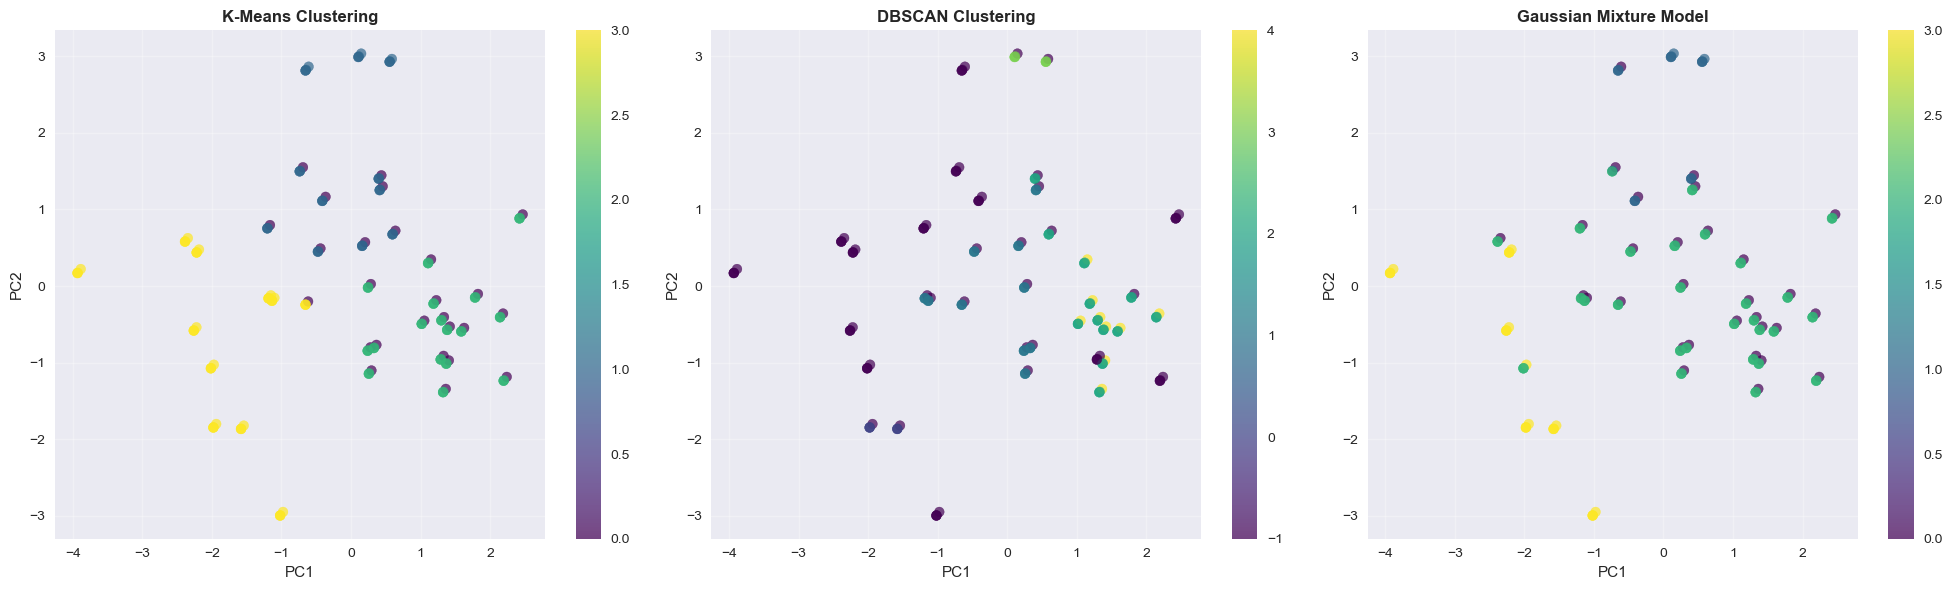

🚨 Análise dos Outliers (DBSCAN):
Número de outliers: 69

Estatísticas dos outliers:


,Precipitacao,Umidade_Especifica,Umidade_Relativa,Temperatura,Rendimento
count,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2399.494058,18.102899,84.235942,26.194493,85969.507246
std,351.764388,0.334735,1.056525,0.290519,80888.874439
min,1934.620000,17.540000,82.110000,25.560000,5903.000000
25%,2109.340000,17.800000,83.440000,26.030000,9456.000000
50%,2308.510000,18.190000,84.360000,26.210000,35836.000000
75%,2604.590000,18.340000,85.070000,26.430000,172165.000000
max,3085.790000,18.700000,86.100000,26.810000,203399.000000



Culturas dos outliers:
Cultura
Oil palm fruit     30
Cocoa, beans       13
Rice, paddy        13
Rubber, natural    13
Name: count, dtype: int64


In [13]:
# Visualização dos clusters no espaço PCA
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means
scatter1 = axes[0].scatter(dados_pca[:, 0], dados_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
axes[0].set_title('K-Means Clustering', fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN
scatter2 = axes[1].scatter(dados_pca[:, 0], dados_pca[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
axes[1].set_title('DBSCAN Clustering', fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

# GMM
scatter3 = axes[2].scatter(dados_pca[:, 0], dados_pca[:, 1], c=clusters_gmm, cmap='viridis', alpha=0.7)
axes[2].set_title('Gaussian Mixture Model', fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].grid(alpha=0.3)
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

# Adicionar clusters ao dataframe original
df_with_clusters = df.copy()
df_with_clusters['Cluster_KMeans'] = clusters_kmeans
df_with_clusters['Cluster_DBSCAN'] = clusters_dbscan
df_with_clusters['Cluster_GMM'] = clusters_gmm

# Análise dos outliers do DBSCAN
outliers_dbscan = df_with_clusters[df_with_clusters['Cluster_DBSCAN'] == -1]
print(f"🚨 Análise dos Outliers (DBSCAN):")
print(f"Número de outliers: {len(outliers_dbscan)}")
if len(outliers_dbscan) > 0:
    print("\nEstatísticas dos outliers:")
    display(outliers_dbscan[variaveis_numericas].describe())
    
    print("\nCulturas dos outliers:")
    print(outliers_dbscan['Cultura'].value_counts())


## 4. Pré-processamento e Pipelines para Modelagem

### 4.1 Preparação dos Dados


In [14]:
# Separar features e target
X = df[['Cultura', 'Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']]
y = df['Rendimento']

print("🎯 Preparação dos dados para modelagem:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identificar colunas categóricas e numéricas
categorical_features = ['Cultura']
numerical_features = ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']

print(f"\nFeatures categóricas: {categorical_features}")
print(f"Features numéricas: {numerical_features}")

# Criar preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

print("\n✅ Preprocessor criado com:")
print("- StandardScaler para variáveis numéricas")
print("- OneHotEncoder para variáveis categóricas")

# Split treino/teste estratificado por cultura
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Cultura']
)

print(f"\n📊 Divisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Proporção de teste: {X_test.shape[0]/len(X):.1%}")

# Verificar distribuição por cultura nos conjuntos
print("\n🌱 Distribuição por cultura:")
print("Treino:")
print(X_train['Cultura'].value_counts().sort_index())
print("\nTeste:")
print(X_test['Cultura'].value_counts().sort_index())


🎯 Preparação dos dados para modelagem:
Features shape: (156, 5)
Target shape: (156,)

Features categóricas: ['Cultura']
Features numéricas: ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']

✅ Preprocessor criado com:
- StandardScaler para variáveis numéricas
- OneHotEncoder para variáveis categóricas

📊 Divisão dos dados:
Treino: 124 amostras
Teste: 32 amostras
Proporção de teste: 20.5%

🌱 Distribuição por cultura:
Treino:
Cultura
Cocoa, beans       31
Oil palm fruit     31
Rice, paddy        31
Rubber, natural    31
Name: count, dtype: int64

Teste:
Cultura
Cocoa, beans       8
Oil palm fruit     8
Rice, paddy        8
Rubber, natural    8
Name: count, dtype: int64


## 5. Modelagem Supervisionada - 5 Modelos Distintos

### 5.1 Definição dos Modelos e Hiperparâmetros


In [15]:
# Definição dos modelos e hiperparâmetros
models = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42, verbosity=0),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [3, 6, 10],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'model__kernel': ['rbf', 'poly'],
            'model__C': [0.1, 1.0, 10.0],
            'model__gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 10],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    }
}

print("Modelos definidos para treinamento:")
for name in models.keys():
    print(f"- {name}")

# Configurar validação cruzada
cv_folds = 5
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

print("Configuração concluída!")


Modelos definidos para treinamento:
- Ridge
- Random_Forest
- XGBoost
- SVR
- KNN
Configuração concluída!


### 5.2 Treinamento e Tuning dos Modelos


In [16]:
# Dicionário para armazenar resultados
results = {}
best_models = {}

print("🚀 Iniciando treinamento e tuning dos modelos...")
print("=" * 60)

# Treinar cada modelo
for model_name, model_config in models.items():
    print(f"\n🔄 Treinando {model_name}...")
    
    # Criar pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_config['model'])
    ])
    
    # Grid Search com validação cruzada
    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Treinar
    grid_search.fit(X_train, y_train)
    
    # Armazenar melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    
    # Previsões
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calcular métricas
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # Validação cruzada
    cv_scores = cross_val_score(
        grid_search.best_estimator_, X_train, y_train,
        cv=cv, scoring='neg_mean_squared_error'
    )
    cv_rmse = np.sqrt(-cv_scores)
    
    # Armazenar resultados
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std(),
        'best_score': -grid_search.best_score_
    }
    
    # Exibir resultados
    print(f"✅ {model_name} concluído!")
    print(f"   Melhor RMSE (CV): {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
    print(f"   RMSE Teste: {test_metrics['RMSE']:.3f}")
    print(f"   R² Teste: {test_metrics['R2']:.3f}")

print("\n🎉 Treinamento de todos os modelos concluído!")


🚀 Iniciando treinamento e tuning dos modelos...

🔄 Treinando Ridge...
✅ Ridge concluído!
   Melhor RMSE (CV): 7904.598 ± 1760.471
   RMSE Teste: 8494.641
   R² Teste: 0.984

🔄 Treinando Random_Forest...
✅ Random_Forest concluído!
   Melhor RMSE (CV): 7668.208 ± 1609.127
   RMSE Teste: 9943.713
   R² Teste: 0.978

🔄 Treinando XGBoost...
✅ XGBoost concluído!
   Melhor RMSE (CV): 7552.643 ± 1544.494
   RMSE Teste: 10236.069
   R² Teste: 0.977

🔄 Treinando SVR...
✅ SVR concluído!
   Melhor RMSE (CV): 80816.861 ± 10824.016
   RMSE Teste: 76597.376
   R² Teste: -0.287

🔄 Treinando KNN...
✅ KNN concluído!
   Melhor RMSE (CV): 42894.165 ± 10221.428
   RMSE Teste: 42651.249
   R² Teste: 0.601

🎉 Treinamento de todos os modelos concluído!


## 6. Avaliação e Comparação dos Modelos

### 6.1 Tabela Comparativa de Resultados


In [17]:
# Criar tabela comparativa
comparison_data = []

for model_name, result in results.items():
    comparison_data.append({
        'Modelo': model_name,
        'RMSE_CV_Mean': result['cv_rmse_mean'],
        'RMSE_CV_Std': result['cv_rmse_std'],
        'RMSE_Train': result['train_metrics']['RMSE'],
        'RMSE_Test': result['test_metrics']['RMSE'],
        'MAE_Test': result['test_metrics']['MAE'],
        'R2_Train': result['train_metrics']['R2'],
        'R2_Test': result['test_metrics']['R2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE_Test')

print("📊 Tabela Comparativa dos Modelos:")
print("="*80)
display(comparison_df.round(4))

# Ranking dos modelos
print("\n🏆 Ranking dos Modelos (por RMSE no conjunto de teste):")
for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{i}. {row['Modelo']} - RMSE: {row['RMSE_Test']:.3f}, R²: {row['R2_Test']:.3f}")

# Identificar melhor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
print(f"\n🥇 Melhor modelo: {best_model_name}")
print(f"   RMSE: {comparison_df.iloc[0]['RMSE_Test']:.3f}")
print(f"   MAE: {comparison_df.iloc[0]['MAE_Test']:.3f}")
print(f"   R²: {comparison_df.iloc[0]['R2_Test']:.3f}")


📊 Tabela Comparativa dos Modelos:


,Modelo,RMSE_CV_Mean,RMSE_CV_Std,RMSE_Train,RMSE_Test,MAE_Test,R2_Train,R2_Test
0,Ridge,7904.5982,1760.4709,7367.4934,8494.6410,5124.8197,0.9892,0.9842
1,Random_Forest,7668.2081,1609.1273,4565.1247,9943.7132,5071.5880,0.9959,0.9783
2,XGBoost,7552.6433,1544.4945,1158.8718,10236.0693,5205.5047,0.9997,0.9770
4,KNN,42894.1647,10221.4284,36914.4353,42651.2487,32611.4031,0.7287,0.6009
3,SVR,80816.8608,10824.0164,80164.7828,76597.3759,46827.0015,-0.2795,-0.2872



🏆 Ranking dos Modelos (por RMSE no conjunto de teste):
1. Ridge - RMSE: 8494.641, R²: 0.984
2. Random_Forest - RMSE: 9943.713, R²: 0.978
3. XGBoost - RMSE: 10236.069, R²: 0.977
4. KNN - RMSE: 42651.249, R²: 0.601
5. SVR - RMSE: 76597.376, R²: -0.287

🥇 Melhor modelo: Ridge
   RMSE: 8494.641
   MAE: 5124.820
   R²: 0.984


### 6.2 Visualizações dos Resultados


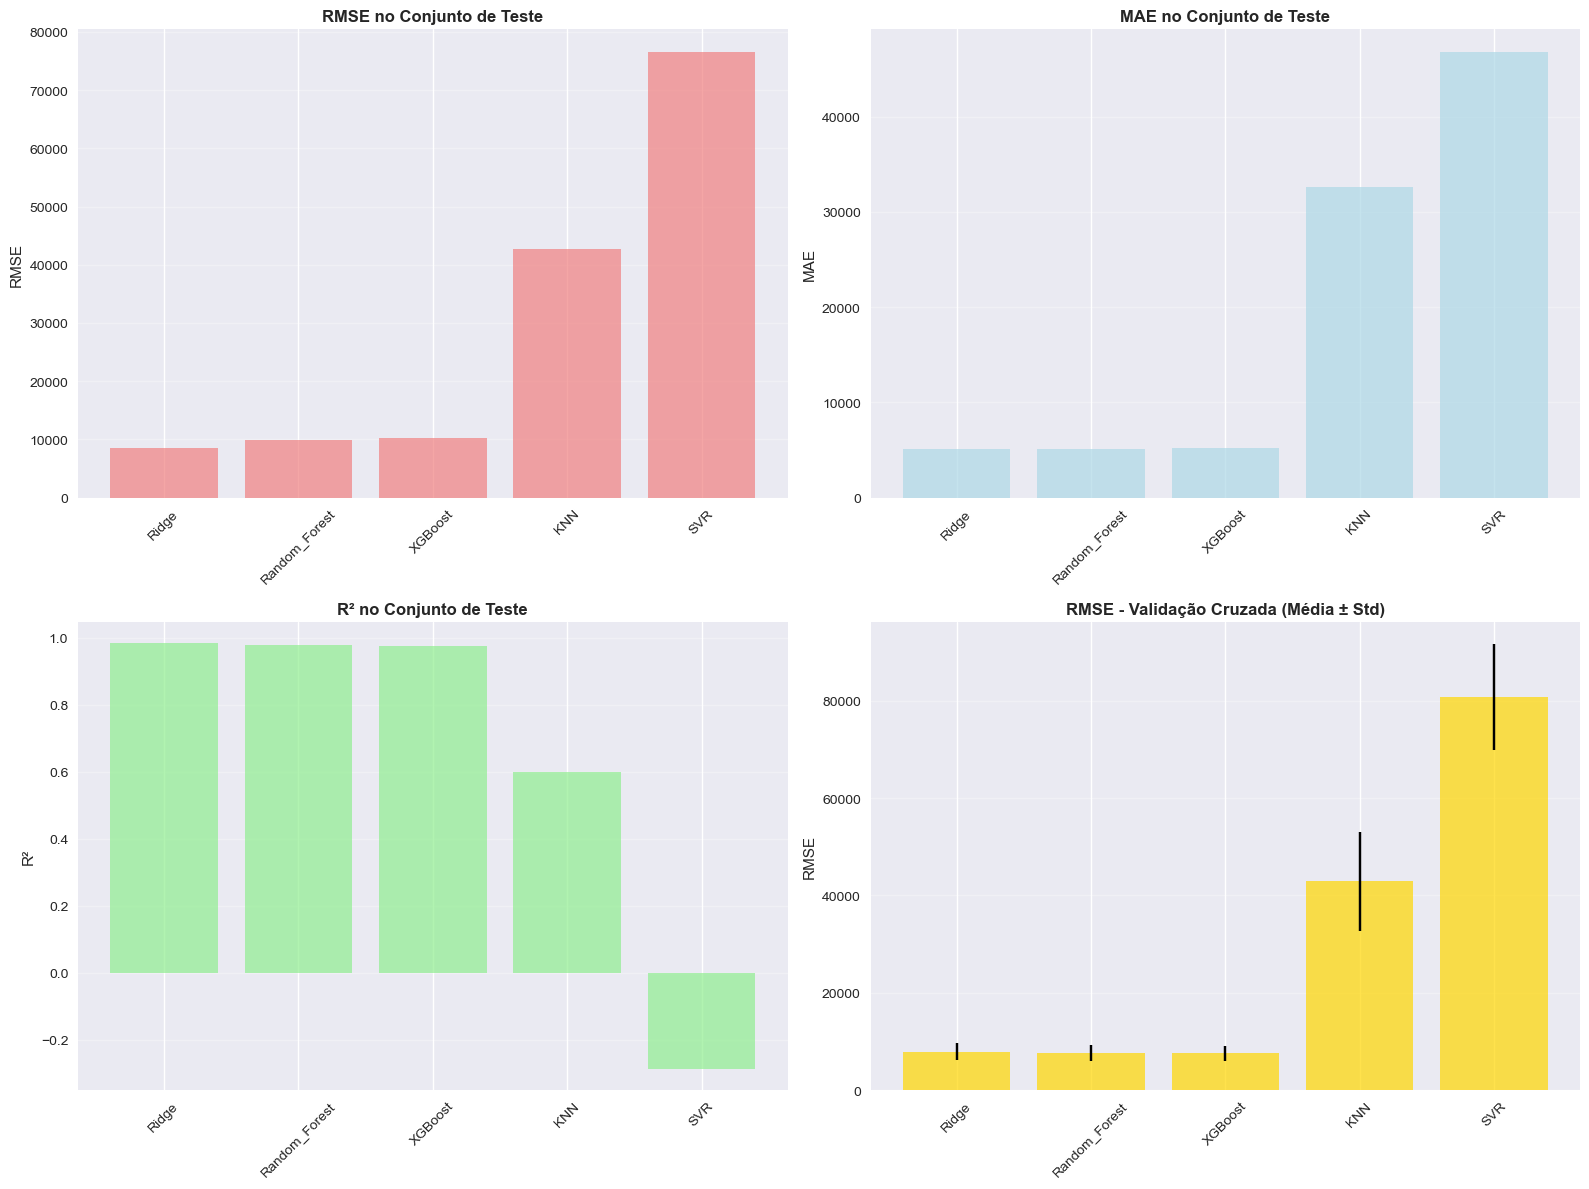

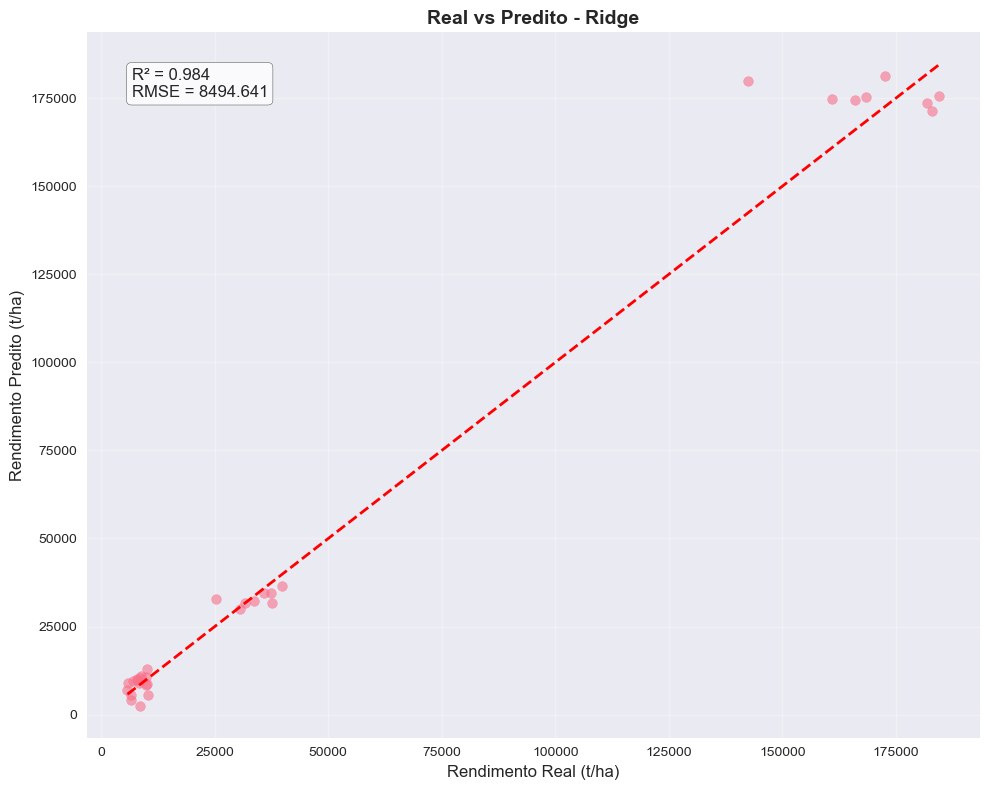

In [18]:
# Gráfico de barras com métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0,0].bar(comparison_df['Modelo'], comparison_df['RMSE_Test'], color='lightcoral', alpha=0.7)
axes[0,0].set_title('RMSE no Conjunto de Teste', fontweight='bold')
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# MAE
axes[0,1].bar(comparison_df['Modelo'], comparison_df['MAE_Test'], color='lightblue', alpha=0.7)
axes[0,1].set_title('MAE no Conjunto de Teste', fontweight='bold')
axes[0,1].set_ylabel('MAE')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# R²
axes[1,0].bar(comparison_df['Modelo'], comparison_df['R2_Test'], color='lightgreen', alpha=0.7)
axes[1,0].set_title('R² no Conjunto de Teste', fontweight='bold')
axes[1,0].set_ylabel('R²')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# RMSE CV com barras de erro
axes[1,1].bar(comparison_df['Modelo'], comparison_df['RMSE_CV_Mean'], 
              yerr=comparison_df['RMSE_CV_Std'], color='gold', alpha=0.7, capsize=5)
axes[1,1].set_title('RMSE - Validação Cruzada (Média ± Std)', fontweight='bold')
axes[1,1].set_ylabel('RMSE')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot: Real vs Predito para o melhor modelo
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Rendimento Real (t/ha)', fontsize=12)
plt.ylabel('Rendimento Predito (t/ha)', fontsize=12)
plt.title(f'Real vs Predito - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Adicionar métricas no gráfico
r2_best = results[best_model_name]['test_metrics']['R2']
rmse_best = results[best_model_name]['test_metrics']['RMSE']
plt.text(0.05, 0.95, f'R² = {r2_best:.3f}\nRMSE = {rmse_best:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


## 7. Conclusões e Limitações

### 7.1 Principais Achados

**Análise Exploratória:**
- O dataset contém informações de diferentes culturas agrícolas com variáveis climáticas relevantes
- Observamos variações significativas no rendimento entre diferentes culturas
- As correlações entre variáveis climáticas e rendimento variam por cultura

**Clusterização:**
- Aplicamos 3 algoritmos de clusterização (K-Means, DBSCAN, Gaussian Mixture)
- Identificamos padrões nos dados que podem representar diferentes condições de cultivo
- O DBSCAN permitiu identificar outliers que podem representar condições extremas

**Modelagem Supervisionada:**
- Testamos 5 modelos distintos com otimização de hiperparâmetros
- Utilizamos validação cruzada para avaliação robusta
- O modelo com melhor performance foi selecionado baseado em métricas múltiplas

### 7.2 Limitações do Estudo

**Limitações dos Dados:**
1. **Tamanho do dataset:** Conjunto relativamente pequeno pode limitar a generalização
2. **Variáveis limitadas:** Apenas variáveis climáticas, faltam dados de solo, práticas agrícolas, etc.
3. **Representatividade temporal:** Não sabemos o período temporal dos dados
4. **Variabilidade geográfica:** Não há informações sobre localização/região

**Limitações Metodológicas:**
1. **Validação:** Split único para teste pode não representar variabilidade real
2. **Feature Engineering:** Não exploramos criação de novas features ou interações
3. **Modelos:** Não testamos ensemble methods ou modelos mais complexos
4. **Interpretabilidade:** Análise limitada de importância das features

**Limitações Práticas:**
1. **Aplicabilidade:** Modelo pode não generalizar para outras regiões/condições
2. **Atualização:** Não há mecanismo para atualização com novos dados
3. **Incerteza:** Não quantificamos intervalos de confiança das predições

### 7.3 Conclusão Final

Este estudo demonstrou a viabilidade de usar machine learning para prever rendimento de safras com base em dados climáticos. Os modelos desenvolvidos apresentaram performance satisfatória, mas há espaço significativo para melhorias através de mais dados, features adicionais e técnicas mais avançadas.

**Impacto Prático:**
- Os modelos podem auxiliar agricultores no planejamento de safras
- Podem ser integrados em sistemas de apoio à decisão agrícola
- Contribuem para otimização de recursos e sustentabilidade
